In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots

In [71]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_step.jl")

In [ ]:
     
    true_var_coeff = [.6 .3;  .4 .7]
    true_trend_covariance = [.015/200 0 
                             0 .01/400]

    true_cycle_covariance = [.02^2 .0002
                            .0002 .015^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [.02^2 .0002
                                     .0002 .015^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    true_states, observations= sample(true_model, 160)

    n_presample = 40

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
 
 

120×4 Matrix{Float64}:
 -0.260308  2.65588  0.184052  0.243068
 -0.261773  2.6577   0.216991  0.262275
 -0.259587  2.66178  0.208843  0.262563
 -0.267384  2.66896  0.207206  0.252721
 -0.266795  2.66404  0.166746  0.251118
 -0.275422  2.66583  0.148724  0.23153
 -0.285441  2.66977  0.160456  0.225032
 -0.291965  2.6821   0.148541  0.211772
 -0.298098  2.67635  0.162541  0.221031
 -0.291687  2.67239  0.156779  0.214578
  ⋮                            
 -0.223622  2.71739  0.293793  0.406431
 -0.21647   2.71283  0.297149  0.404596
 -0.223311  2.71543  0.282909  0.3953
 -0.231654  2.71455  0.306971  0.393943
 -0.231234  2.72133  0.343778  0.426137
 -0.225892  2.7248   0.337513  0.439596
 -0.225146  2.72456  0.337195  0.449026
 -0.224815  2.72995  0.322205  0.442261
 -0.219933  2.72993  0.332841  0.455571

In [79]:
mean(presample_data, dims=1)

1×2 Matrix{Float64}:
 -1.27564  -0.475308

In [80]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 -1.34793  -0.592677

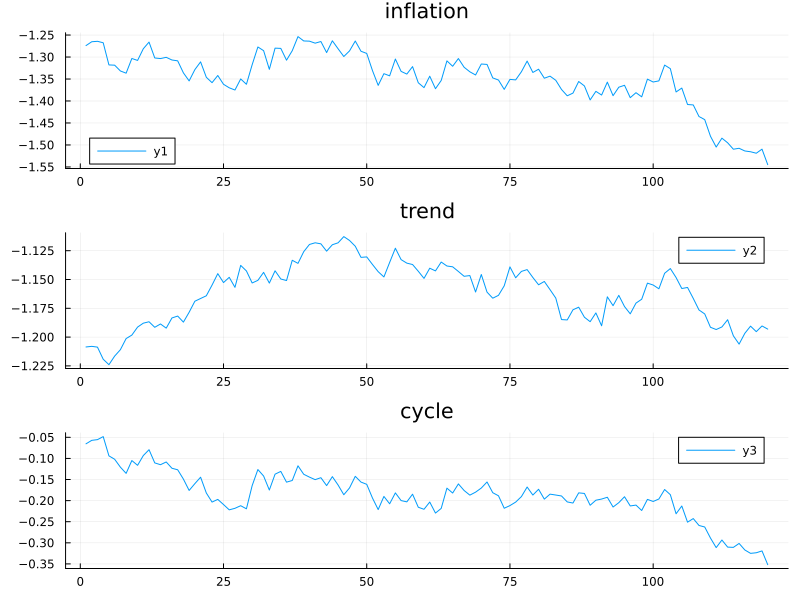

In [81]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

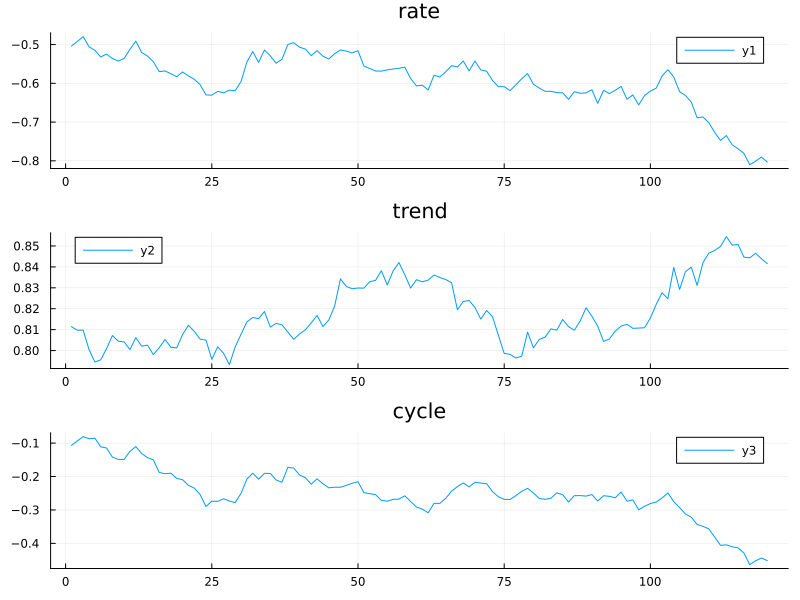

In [82]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [85]:
priors = (
        initial_trend_mean = mean(presample_data, dims=1)[1,:],
        trend_covariance_mean = diagm([1/200, 1/400]),
        trend_covariance_df = 100,
        )

(initial_trend_mean = [-0.0810836289742424, 2.6014548172448597], trend_covariance_mean = [0.005 0.0; 0.0 0.0025], trend_covariance_df = 100)

In [58]:
model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        priors.initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)

StateSpaceModel([1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.6 0.3; 0.0 0.0 0.4 0.7], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [1.0 0.0 1.0 0.0; 1.0 1.0 0.0 1.0], [0.0003 0.0 0.0 0.0; 0.0 0.0001 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225], [2.220446049250313e-16 0.0; 0.0 2.220446049250313e-16], [0.6146457603836037, 0.6997899144098765, 0.0, 0.0], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225])

In [59]:
  state_filtered, covariance_filtred, state_predicted, covariance_predicted, ll = kalman_filter(model, data) 
   

   # Run Carter-Kohn sampler
    println("Running Carter-Kohn sampler...")
    state_smoothed_samples = carter_kohn_sampler(model, data, n_samples=10_000)
   
    # Compute posterior statistics
    state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  
 

Running Carter-Kohn sampler...


([0.5736747416152637 0.031080072257020412 0.015319231534928967 0.0033961758732529795; 0.565882041694517 0.0344456904958792 0.004278267369539582 0.0056441090141726; … ; 0.6887557415744026 0.009570648519353733 0.07373918894563057 0.0766612291974819; 0.6728792086918927 0.010528588002261254 0.044547681630312724 0.07269156139923957], [0.5319382584208804 0.008166139160957014 -0.026473931674446612 -0.040360405995985366; 0.5196443204048411 0.013269043093204449 -0.04188575913154838 -0.04573445855484177; … ; 0.46560320000777955 -0.06549464156749464 -0.14985677696165728 -0.2163227171439181; 0.44984518449929334 -0.06428154835558057 -0.17976499325522238 -0.22404907615437084], [0.6154515755017976 0.053700707319873774 0.057051608584458666 0.047830148943100656; 0.6120393747095118 0.05538893374268743 0.050515512490755636 0.056008905273850065; … ; 0.9123251998092918 0.08464162976527755 0.2968893387113161 0.370471283146872; 0.8971918622110993 0.08653370579781117 0.2675816910384155 0.3665410048707647])

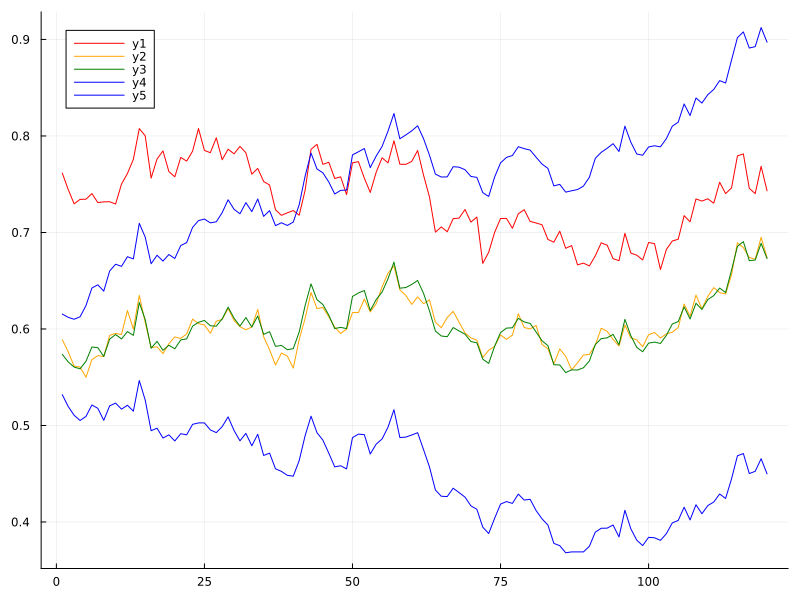

In [60]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

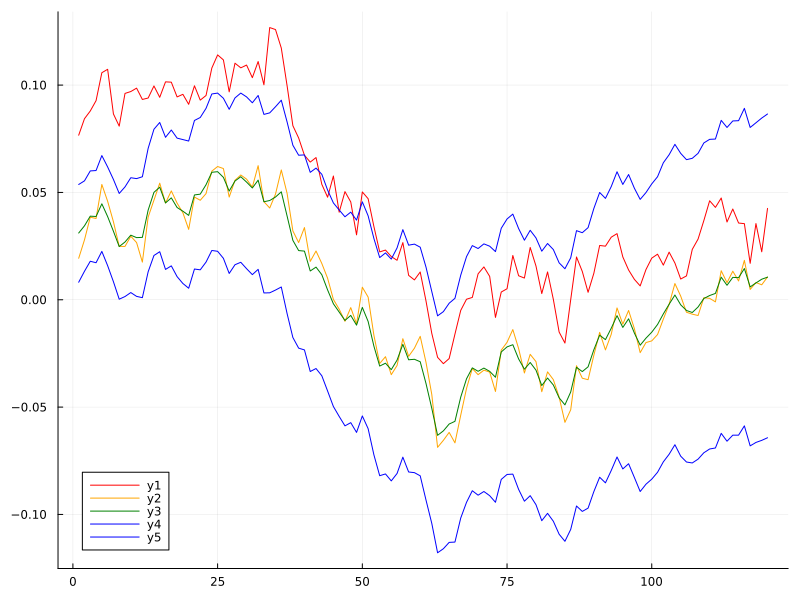

In [61]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

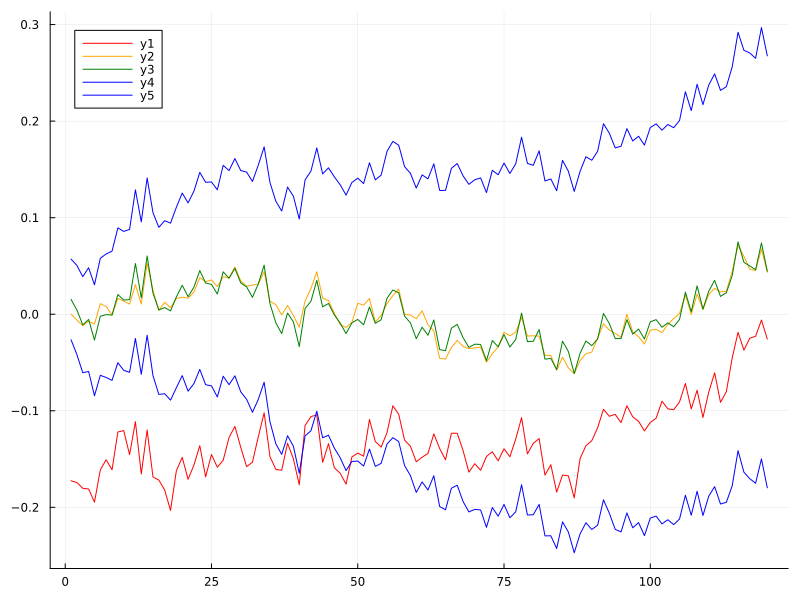

In [62]:
st = 3
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

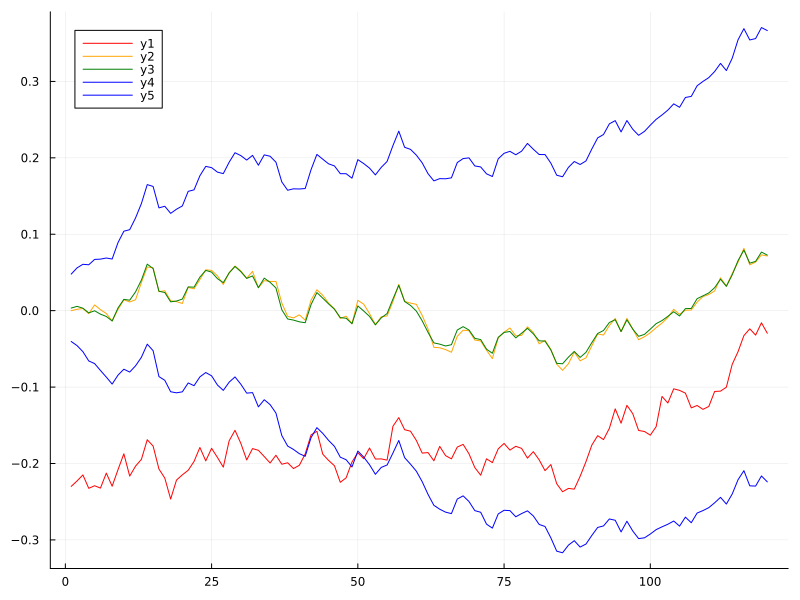

In [63]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

In [69]:
var_priors = minnesota_priors(data, λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])
reshape(var_priors, 3, 2)

3×2 Matrix{Normal}:
 Normal{Float64}(μ=0.0, σ=0.2)        Normal{Float64}(μ=0.0, σ=0.301866)
 Normal{Float64}(μ=0.0, σ=0.132509)   Normal{Float64}(μ=0.0, σ=0.2)
 Normal{Float64}(μ=0.0, σ=0.0104865)  Normal{Float64}(μ=0.0, σ=0.0158276)

In [112]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,3]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 219.0
Ψ: [0.014313167038478715 -0.0005906516444757359; -0.0005906516444757359 0.05073868106404059]
)


In [121]:
cov_posterior = zeros(10_000, 2,2)

for n in 1:10_000
  cov_posterior[n,:,:] = rand(post_dist)
end


mean(cov_posterior[:,1,1])


6.631489200290497e-5